In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import sys
import argparse
import os

In [2]:
# Load and configure the ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
def load_image(file_path):
    img = Image.open(file_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

In [4]:
def get_target_class_index(label, json_path='imagenet_index.json'):
    with open(json_path) as json_file:
        mapping_dict = json.load(json_file)
    return mapping_dict.get(label.lower().replace('_', ' '), None)

In [5]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

In [6]:
def clip_eps(tensor, eps):
    return torch.clamp(tensor, -eps, eps)

In [7]:
def generate_target_adversaries(model, base_image, delta, original_class_index, target_class_index, steps, epsilon, lr):
    optimizer = torch.optim.Adam([delta], lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    for step in range(steps):
        optimizer.zero_grad()
        adversary = (base_image + delta).clamp(0, 1)
        predictions = model(adversary)
        original_loss = -loss_fn(predictions, torch.tensor([original_class_index]))
        target_loss = loss_fn(predictions, torch.tensor([target_class_index], dtype=torch.long))
        total_loss = original_loss + target_loss
        if step % 10 == 0:
            print(f'step: {step}, loss: {total_loss.item()}')
        total_loss.backward()
        optimizer.step()
        with torch.no_grad():
            delta.data = clip_eps(delta, eps=epsilon)
    return delta

In [10]:
target_class="gorilla"
image_file="panda.jpeg"

json_path ='imagenet_index.json'
target_index = get_target_class_index(target_class, json_path)
print(target_index)
if target_index is None:
    print('Error: Target class does not exist in ImageNet.')
    sys.exit(0)

base_image = preprocess_image(image_file)
delta = torch.zeros_like(base_image, requires_grad=True)

epsilon = 0.01  # Perturbation limit
learning_rate = 0.01  # Learning rate for the optimizer
num_steps = 100  # Number of optimization steps

original_index=model(base_image).argmax(dim=1)
# Run adversarial generation
delta_updated = generate_target_adversaries(model, base_image, delta, original_index, int(target_index), num_steps, epsilon, learning_rate)

# Create and save the adversarial image
adversarial_image = (base_image + delta_updated).clamp(0, 1).detach()
predicted_adv=model(adversarial_image).argmax(dim=1)
adversarial_image_pil = transforms.ToPILImage()(adversarial_image.squeeze())
adversarial_image_pil.save('output.png')

366
step: 0, loss: 1.054788589477539
step: 10, loss: -4.145772933959961
step: 20, loss: -4.267388820648193
step: 30, loss: -4.301578521728516
step: 40, loss: -4.315365791320801
step: 50, loss: -4.324565887451172
step: 60, loss: -4.329647541046143
step: 70, loss: -4.333188056945801
step: 80, loss: -4.33502197265625
step: 90, loss: -4.336453437805176


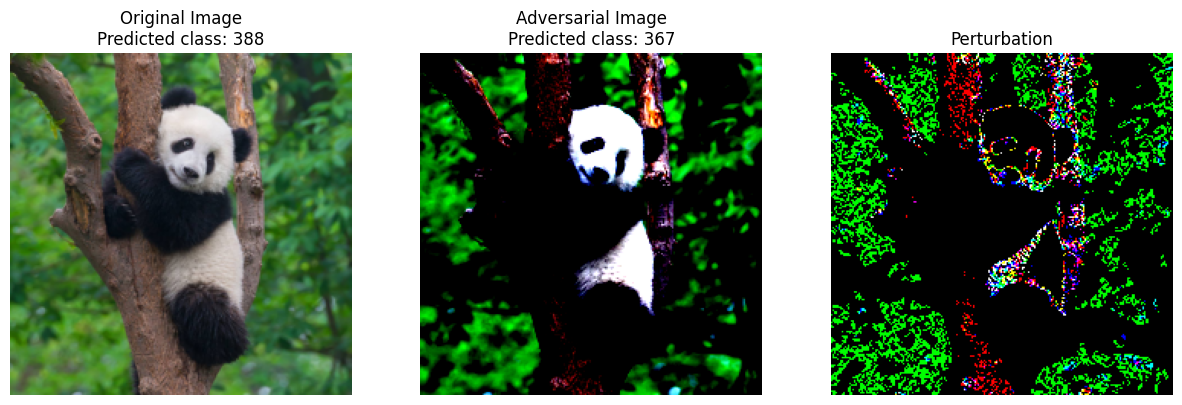

In [13]:
base_image = load_image(image_file)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(transforms.ToPILImage()(base_image.squeeze().detach()))
axs[0].set_title(f'Original Image\nPredicted class: {original_index.item()}')
axs[1].imshow(transforms.ToPILImage()(adversarial_image.squeeze().detach()))
axs[1].set_title(f'Adversarial Image\nPredicted class: {predicted_adv.item()}')
axs[2].imshow(transforms.ToPILImage()(delta_updated.squeeze().detach()))
axs[2].set_title('Perturbation')
for ax in axs:
    ax.axis('off')
plt.show()